In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision

Total number of images in [URTICARIA HIVES] in train set: 1405
Total number of images in [PSORIASIS PICTURES LICHEN PLANUS AND RELATED DISEASES] in train set: 1405
Total number of images in [LUPUS AND OTHER CONNECTIVE TISSUE DISEASES] in train set: 1405
Total number of images in [ATOPIC DERMATITIS PHOTOS] in train set: 1405
Total number of images in [MELANOMA SKIN CANCER NEVI AND MOLES] in train set: 1405
Total number of images in [URTICARIA HIVES] in test set: 53
Total number of images in [PSORIASIS PICTURES LICHEN PLANUS AND RELATED DISEASES] in test set: 352
Total number of images in [LUPUS AND OTHER CONNECTIVE TISSUE DISEASES] in test set: 105
Total number of images in [ATOPIC DERMATITIS PHOTOS] in test set: 123
Total number of images in [MELANOMA SKIN CANCER NEVI AND MOLES] in test set: 116


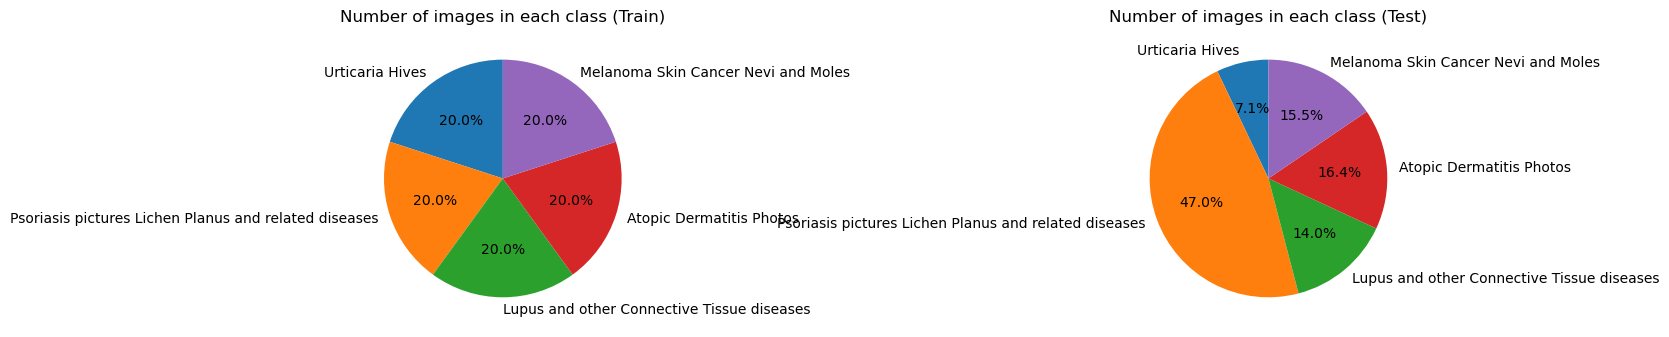

In [25]:
# Função para contar o número de arquivos em um diretório
def count_files(directory):
    return len([item for item in os.listdir(directory) if os.path.isfile(os.path.join(directory, item))])

# Definindo os caminhos dos diretórios de treinamento e teste
train_folder = '/Users/hugopereira/Github/Left4Health_3rdProject/ClassificationOfSkinDiseases/DataProcessed/train'
test_folder = '/Users/hugopereira/Github/Left4Health_3rdProject/ClassificationOfSkinDiseases/DataProcessed/test'

# Dicionários para armazenar o número de imagens em cada classe de doença de pele
train_diseases = {}
test_diseases = {}

# Função para contar o número de imagens em cada classe de doença de pele nos diretórios de treinamento e teste
def count_images_in_folders(folder, diseases_dict):
    for label_folder in os.listdir(folder):
        label_path = os.path.join(folder, label_folder)
        if os.path.isdir(label_path):
            diseases_dict[label_folder] = count_files(label_path)

# Contando o número de imagens em cada classe de doença de pele nos diretórios de treinamento e teste
count_images_in_folders(train_folder, train_diseases)
count_images_in_folders(test_folder, test_diseases)

# Imprimindo o número de imagens em cada classe de doença de pele nos conjuntos de treinamento e teste
for label_folder, num_images in train_diseases.items():
    print(f'Total number of images in [{label_folder.upper()}] in train set: {num_images}')

for label_folder, num_images in test_diseases.items():
    print(f'Total number of images in [{label_folder.upper()}] in test set: {num_images}')

# Plotando o número de imagens em cada classe de doença de pele nos conjuntos de treinamento e teste usando um gráfico de pizza
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.pie(train_diseases.values(), labels=train_diseases.keys(), autopct='%1.1f%%', startangle=90)
plt.title('Number of images in each class (Train)')

plt.subplot(1, 2, 2)
plt.pie(test_diseases.values(), labels=test_diseases.keys(), autopct='%1.1f%%', startangle=90)
plt.title('Number of images in each class (Test)')

plt.tight_layout()
plt.show()

In [31]:
# Função para obter os dados de treinamento e validação

# Função para obter os dados de treinamento e validação
def get_data(train_folder, test_folder, image_size=(250, 250), batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=20,
    )

    train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        seed=10
    )

    validation_generator = train_datagen.flow_from_directory(
        train_folder,   
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        seed=10
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

# Função para treinar o modelo
def train_model(model, train_generator, validation_generator, epochs):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision()]
    )

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        verbose=1,
    )

    return model, history

# Função para avaliar o modelo
def evaluate_model(model, history, test_generator, test_folder): 
    # Predict
    y_pred = model.predict(test_generator)

    # Convert predictions to labels
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = test_generator.classes

    # Calculate precision, recall, and AUC
    precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
    recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
    auc = roc_auc_score(y_true_labels, y_pred_labels, average='weighted')

    # Plot the training and validation accuracy and loss at each epoch
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    # Plot training and validation metrics of the model
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot the training and validation loss at each epoch
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()

    print("Precision:", precision)
    print("Recall:", recall)
    print("AUC:", auc)

    plt.show()
    
# Função para salvar o modelo
def save_model(model, model_name, history, train_folder): 
    # Create a folder to save models if it does not exist
    if not os.path.exists('Saved_Models'):
        os.mkdir('Saved_Models')
    
    # Create a folder to save the model if it does not exist
    if not os.path.exists('Saved_Models/' + model_name):
        os.mkdir('Saved_Models/' + model_name)
    
    # Save the model
    model.save('Saved_Models/' + model_name + '/' + model_name + '.h5')

    # Save the evaluation of model
    evaluate_model(model, history, None, test_folder)
    plt.savefig('Saved_Models/' + model_name + '/' + model_name + '_evaluation.png')

    # Save the model architecture
    tf.keras.utils.plot_model(
        model,
        to_file='Saved_Models/' + model_name + '/' + model_name + '.png',
        show_shapes=True,
        show_layer_names=True,
    )

    # Save the model history into a csv 
    hist_df = pd.DataFrame(history.history)
    hist_csv_file = 'Saved_Models/' + model_name + '/' + model_name + '_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

In [30]:
# Definição da arquitetura da CNN
def CNN_model(input_shape=(250, 250, 3)):
    model = Sequential([
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        GlobalAveragePooling2D(),
        
        Dense(units=64, activation='relu'),
        Dense(units=5, activation='softmax')
    ])
    
    return model

# Execução do modelo CNN
def run_cnn_model(train_folder, test_folder, epochs=1):
    # Obtendo os dados
    train_generator, validation_generator, test_generator = get_data(train_folder, test_folder)
    
    # Criando e compilando o modelo CNN
    model = CNN_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Treinando o modelo
    model.fit(train_generator, validation_data=validation_generator, epochs=epochs, verbose=1)
    
    # Avaliando o modelo
    _, history = train_model(model, train_generator, validation_generator, epochs)
    evaluate_model(model, history, test_generator, test_folder)
    
    # Salvando o modelo
    save_model(model, 'CNN_model', history, train_folder)

# Executando o modelo CNN
run_cnn_model(train_folder, test_folder)

Found 5620 images belonging to 5 classes.
Found 1405 images belonging to 5 classes.
Found 749 images belonging to 5 classes.


2024-04-03 20:55:17.039992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


176/176 [==============================] - ETA: 0s - loss: 1.5774 - accuracy: 0.2621

2024-04-03 21:00:04.602646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


176/176 [==============================] - 307s 2s/step - loss: 1.5774 - accuracy: 0.2621 - val_loss: 1.5508 - val_accuracy: 0.2918


NameError: name 'Precision' is not defined

In [19]:
# Definição da arquitetura da ResNet
def ResNet_model(input_shape=(250, 250, 3)):
    input_layer = Input(shape=input_shape)
    resized_input = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(input_layer)
    
    resnet_base = ResNet50(include_top=False, weights=None, input_tensor=resized_input)
    resnet_output = resnet_base.output
    
    x = GlobalAveragePooling2D()(resnet_output)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    
    output_layer = Dense(units=5, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

# Execução do modelo ResNet
def run_resnet_model(train_folder, test_folder, epochs=10):
    # Obtendo os dados
    train_generator, validation_generator, test_generator = get_data(train_folder, test_folder)
    
    # Criando e compilando o modelo ResNet
    model = ResNet_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Treinando o modelo
    model.fit(train_generator, validation_data=validation_generator, epochs=epochs, verbose=1)
    
    # Avaliando o modelo
    _, history = train_model(model, train_generator, validation_generator, epochs)
    evaluate_model(model, history, test_generator, test_folder)
    
    # Salvando o modelo
    save_model(model, 'ResNet_model', history, train_folder)

# Executando o modelo ResNet
run_resnet_model(train_folder, test_folder)

In [ ]:
# Função para definir a arquitetura do modelo VGG16
def VGG16_model(weights=None, input_shape=(250, 250, 3)):
    # Input Layer
    input_layer = Input(shape=input_shape)

    # Resize input images to 224x224 to match VGG16 input shape
    resized_input = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(input_layer)

    # Importando o modelo VGG16 da API do Keras
    vgg16_base = VGG16(include_top=False, weights=weights, input_tensor=resized_input)

    # Removendo a última camada do VGG16, que é um GlobalAveragePooling2D
    vgg16_layer = vgg16_base.layers[-1].output

    # Camada de saída
    x = Flatten()(vgg16_layer)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    output_layer = Dense(units=5, activation='softmax')(x)

    # Modelo
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Executando o modelo VGG16
def run_vgg16_model(train_folder, test_folder, epochs=10):
    # Obtendo os dados
    train_generator, validation_generator, test_generator = get_data(train_folder, test_folder)
    
    # Criando e compilando o modelo VGG16
    model = VGG16_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Treinando o modelo
    model.fit(train_generator, validation_data=validation_generator, epochs=epochs, verbose=1)
    
    # Avaliando o modelo
    _, history = train_model(model, train_generator, validation_generator, epochs)
    evaluate_model(model, history, test_generator, test_folder)
    
    # Salvando o modelo
    save_model(model, 'VGG16_model', history, train_folder)

# Executando o modelo VGG16
run_vgg16_model(train_folder, test_folder)